<a href="https://colab.research.google.com/github/elisecolin/Tutorials_Remote_Sensing_notebooks/blob/main/Generation_Video_Speckle_Funny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌀 Dynamic Speckle Simulation from Text Mask

This notebook demonstrates how to generate a **synthetic dynamic speckle video** driven by a user-defined **text mask**, where the local speckle decorrelation rate varies according to the shape of the text. The procedure simulates temporal fluctuations in coherent imaging (such as SAR or laser speckle imaging), with a spatially varying activity profile.

## 🔍 Objectives

- Generate a time series of 2D speckle patterns with controllable dynamics.
- Modulate the **temporal decorrelation rate** based on the intensity of a binary input mask (e.g., a text image).
- Visualize the synthetic speckle video.
- Estimate and display an **activity map** reflecting the local temporal variability.

## 🛠 Applications

This simulation is useful for:
- Understanding decorrelation in coherent imaging.
- Testing temporal analysis methods (e.g., activity index, entropy, temporal contrast).
- Educational demonstrations of speckle dynamics.

---

> ⚠️ Note: This is a synthetic, pedagogical example and does not reflect physical SAR or LSI imaging processes in detail.


In [1]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager

def text_to_binary_mask(text, font_size=40, padding=10):
    # Load an available system font
    font_path = font_manager.findfont("DejaVu Sans")
    font = ImageFont.truetype(font_path, font_size)

    # Temporary image to calculate the text bounding box
    tmp_img = Image.new('L', (1, 1))
    tmp_draw = ImageDraw.Draw(tmp_img)

    # Get the bounding box of the text: (left, top, right, bottom)
    bbox = tmp_draw.textbbox((0, 0), text, font=font)

    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]

    # Calculate final image size with padding
    img_width = text_width + 2 * padding
    img_height = text_height + 2 * padding

    # Create final image and draw text shifted to accommodate descenders
    img = Image.new('L', (img_width, img_height), color=0)
    draw = ImageDraw.Draw(img)

    # Shift text up by bbox[1] to correctly include descenders
    text_position = (padding - bbox[0], padding - bbox[1])
    draw.text(text_position, text, font=font, fill=255)

    # Convert to binary mask: text pixels = 1, background = 0
    np_img = np.array(img)
    binary_mask = (np_img > 0).astype(np.uint8)

    return binary_mask


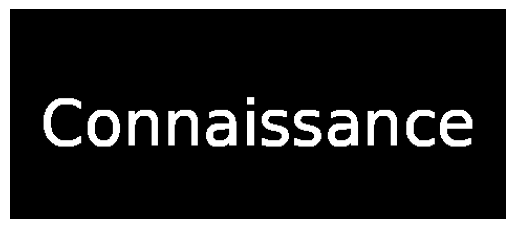

In [2]:
MyText=" \n \n Connaissance \n "
mask = text_to_binary_mask(MyText, font_size=60)

plt.figure()
plt.imshow(mask, cmap='gray')
plt.axis("off")
plt.show()


In [3]:
import numpy as np
from numpy.fft import fft2, ifft2

def perfect_lowpass(u, Dky, Dkx, normalize=False):
    """
    Applies a perfect low-pass filter with a rectangular transfer function
    of size (Dky x Dkx) in the frequency domain.

    Parameters
    ----------
    u : (Ny, Nx) 2D array
        Input image.
    Dky : int
        Height of the rectangular filter (in frequency samples).
    Dkx : int
        Width of the rectangular filter (in frequency samples).
    normalize : bool, optional
        If True, scales the output to preserve the root mean square (RMS) energy
        of the input. Otherwise, the output energy is reduced by a factor of
        (Ny * Nx) / (Dky * Dkx). Default is False.

    Returns
    -------
    u_hat : (Ny, Nx) ndarray
        Filtered image.
    """
    Ny, Nx = u.shape
    U = fft2(u)
    U_hat = np.zeros((Ny, Nx), dtype=complex)

    # Build a 2D rectangular mask in the frequency domain
    fft_sincd_y = discrete_rectangular_function(Ny, Dky).reshape((Ny, 1))
    fft_sincd_x = discrete_rectangular_function(Nx, Dkx).reshape((1, Nx))
    fft_sincd = np.dot(fft_sincd_y, fft_sincd_x)

    # Apply the low-pass filter
    U_hat = U * fft_sincd
    u_hat = ifft2(U_hat)

    if normalize:
        # Scale to preserve energy: ||u_hat||² = ||u||²
        u_hat *= np.sqrt((Ny * Nx) / (Dky * Dkx))

    # Remove imaginary part if input was real
    if not np.iscomplexobj(u):
        u_hat = np.real(u_hat)

    return u_hat


def discrete_rectangular_function(N, Dk):
    """
    Returns a discrete rectangular window of width Dk over [0, N-1],
    centered around the middle of the array. It accounts for both
    even and odd Dk by adjusting edges.

    Parameters
    ----------
    N : int
        Total length of the signal.
    Dk : int
        Width of the rectangular window.

    Returns
    -------
    f : (N,) ndarray
        Discrete rectangular function.
    """
    f = np.zeros(N)

    if Dk % 2 == 0:
        f[: Dk // 2] = 1
        f[-Dk // 2 + 1 :] = 1
        f[-Dk // 2] = 0.5
        f[Dk // 2] = 0.5
    else:
        f[: Dk // 2 + 1] = 1
        f[-(Dk // 2) :] = 1

    return f


In [4]:

import matplotlib as mpl
import copy

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import copy

def save_image_with_colormap(
    fname,
    u,
    cmap="gray",
    log=False,
    height=None,
    vmin=None,
    vmax=None,
):
    """
    Save a 2D image array using a specific colormap and display parameters.

    Parameters
    ----------
    fname : str
        Output filename (e.g., 'output.png').
    u : numpy.ndarray
        2D image array to save.
    cmap : str, optional
        Matplotlib colormap name. Default is "gray".
    log : bool, optional
        If True, apply logarithmic color scaling. Default is False.
    height : int, optional
        Output image height in pixels. If None, use the input image height.
        Default is None.
    vmin : float, optional
        Lower bound for colormap normalization. If None, defaults to u.min().
    vmax : float, optional
        Upper bound for colormap normalization. If None, defaults to u.max().
    """

    ny, nx = u.shape

    if height is None:
        height = ny

    # Compute figure size in inches to match desired pixel height
    dpi = height
    figsize = (nx / ny, 1)

    fig = plt.figure(frameon=False, dpi=dpi)
    fig.set_size_inches(*figsize, forward=False)

    # Add axis with no borders or labels
    ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
    ax.set_axis_off()
    fig.add_axes(ax)

    # Copy the colormap to allow modification (e.g., set bad values)
    my_cmap = copy.copy(mpl.colormaps[cmap])

    if log:
        my_cmap.set_bad((0, 0, 0))  # Define color for invalid (NaN or <=0) values
        norm = mpl.colors.LogNorm(
            vmin=vmin if vmin is not None else np.nanmin(u[u > 0]),
            vmax=vmax if vmax is not None else np.nanmax(u),
        )
    else:
        norm = mpl.colors.Normalize(
            vmin=vmin if vmin is not None else np.nanmin(u),
            vmax=vmax if vmax is not None else np.nanmax(u),
        )

    ax.imshow(u, cmap=my_cmap, norm=norm)

    fig.savefig(fname, dpi=dpi, bbox_inches="tight", pad_inches=0)
    plt.close()


In [5]:
import os
import numpy as np

In [6]:
Ny, Nx = np.shape(mask)
l0x = l0y = 4  # Dimensions of a speckle grain
Dkx = Nx // l0x  # Width of the ideal low-pass filter corresponding to the speckle size
Dky = Ny // l0y  # Height of the ideal low-pass filter corresponding to the speckle size


In [7]:
# R² between consecutive images in the "low activity" region of the image  (slow decorrelation)
a1 = 0.9
# R² between consecutive images in the "high activity" region of the image (fast decorrelation)
a2 = 0.65
# Total number of frames
N = 1000
# Number of frames per "batch" for computing an intensity image
N_img_int = 50
os.makedirs("video_speckle", exist_ok=True)
# Raw complex amplitude (before low-pass filtering)
A = np.zeros((Ny, Nx, N), dtype=complex)
Re_A = np.random.normal(size=(Ny, Nx))
Im_A = np.random.normal(size=(Ny, Nx))
A[:, :, 0] = Re_A + 1j * Im_A
# Amplitude after ideal low-pass filtering
A_cam = np.zeros((Ny, Nx, N))
A_cam[:, :, 0] = np.abs(perfect_lowpass(A[:, :, 0], Dky, Dkx))
# Intensity image sequence
I = np.zeros((Ny, Nx, N // N_img_int))


In [8]:
import os
import numpy as np
import imageio.v2 as imageio
from tqdm import tqdm

# Initialize memory containers for GIF frames
gif_frames_A = []
gif_frames_I = []

for n in tqdm(range(1, N), desc="Generating speckle sequence"):
    # Generate new complex amplitude image
    Re_A = np.random.normal(size=(Ny, Nx))
    Im_A = np.random.normal(size=(Ny, Nx))
    new_A = Re_A + 1j * Im_A

    # Update complex amplitude using two different speckle models
    A[:, :, n] = (
        (mask == 0) * (np.sqrt(a1) * A[:, :, n - 1] + np.sqrt(1 - a1) * new_A)
        + (mask == 1) * (np.sqrt(a2) * A[:, :, n - 1] + np.sqrt(1 - a2) * new_A)
    )

    # Apply ideal low-pass filter
    A_cam[:, :, n] = np.abs(perfect_lowpass(A[:, :, n], Dky, Dkx, normalize=True))

    # Add current amplitude image to GIF frames
    gif_frames_A.append((A_cam[:, :, n] * 255 / A_cam[:, :, n].max()).astype(np.uint8))

    if n % N_img_int == N_img_int - 1:
        # Compute intensity image by summing squared amplitudes over last N_img_int frames
        I[:, :, n // N_img_int] = np.sum(
            A_cam[:, :, n - N_img_int + 1 : n + 1] ** 2, axis=-1
        )

        # Add current intensity frame to GIF frames
        current_I = I[:, :, n // N_img_int]
        gif_frames_I.append((current_I * 255 / current_I.max()).astype(np.uint8))

# Compute contrast image
K = np.std(I, axis=-1) / np.mean(I, axis=-1)

# Save GIFs
os.makedirs("video_speckle", exist_ok=True)

durations_A = [0.04] * len(gif_frames_A)
durations_I = [2.0] * len(gif_frames_I)
imageio.mimsave(os.path.join("video_speckle", "A.gif"), gif_frames_A, duration=durations_A)
imageio.mimsave(os.path.join("video_speckle", "I.gif"), gif_frames_I, duration=durations_I)




Generating speckle sequence: 100%|██████████| 999/999 [01:08<00:00, 14.49it/s]


In [9]:
from moviepy.editor import ImageSequenceClip
import os

# Convert uint8 grayscale frames to RGB (required by moviepy)
frames_A_rgb = [np.stack([frame]*3, axis=-1) for frame in gif_frames_A]
frames_I_rgb = [np.stack([frame]*3, axis=-1) for frame in gif_frames_I]

# Create video clips
clip_A = ImageSequenceClip(frames_A_rgb, fps=25)  # 25 frames per second
clip_I = ImageSequenceClip(frames_I_rgb, durations=[2.0] * len(frames_I_rgb))  # 2 seconds per frame

# Save videos
clip_A.write_videofile("video_speckle/A.mp4", codec="libx264", fps=25)
clip_I.write_videofile("video_speckle/I.mp4", codec="libx264", fps=1/2.0)


Moviepy - Building video video_speckle/A.mp4.
Moviepy - Writing video video_speckle/A.mp4



Moviepy - Done !
Moviepy - video ready video_speckle/A.mp4
Moviepy - Building video video_speckle/I.mp4.
Moviepy - Writing video video_speckle/I.mp4



Moviepy - Done !
Moviepy - video ready video_speckle/I.mp4


In [10]:
MAI=1/K**2


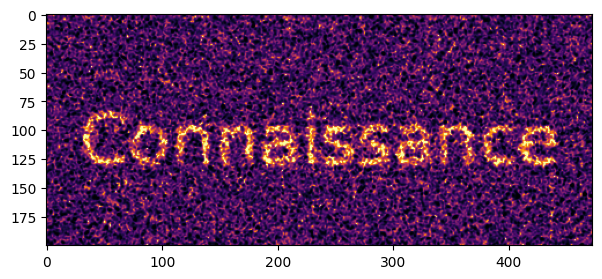

In [11]:
p1=np.percentile(MAI,1)
p2=np.percentile(MAI,99)

plt.figure(figsize=(15,3))
plt.imshow(MAI, cmap='inferno',vmin=p1,vmax=p2)
plt.show()


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import io
from PIL import Image

def get_MAI_colormapped_frame(MAI, cmap="inferno", vmin=None, vmax=None):
    # Normalize MAI and apply colormap
    p1 = np.percentile(MAI, 1) if vmin is None else vmin
    p2 = np.percentile(MAI, 99) if vmax is None else vmax

    fig, ax = plt.subplots(figsize=(15, 3), dpi=100)
    ax.imshow(MAI, cmap=cmap, vmin=p1, vmax=p2)
    ax.axis("off")

    buf = io.BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight", pad_inches=0)
    plt.close(fig)
    buf.seek(0)
    img = Image.open(buf).convert("RGB")
    return np.array(img)
# Step 1: create the final image array
MAI_colored = get_MAI_colormapped_frame(MAI)


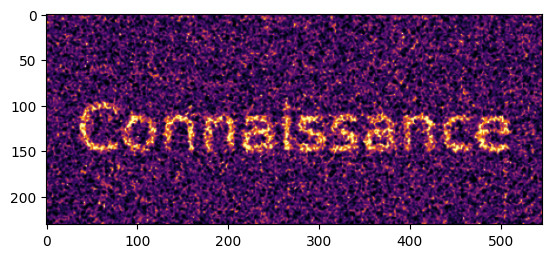

In [13]:
plt.figure()
plt.imshow(MAI_colored)

In [14]:
def generate_dynamic_transition_clip(A_frames, MAI_colored, duration=1.5, fps=25):
    """
    Overlays the static MAI_colored image progressively over the last frames of A.

    Parameters
    ----------
    A_frames : list of np.ndarray
        Sequence of grayscale amplitude frames (uint8) to use in the transition.
    MAI_colored : np.ndarray
        Final RGB image to reveal progressively.
    duration : float
        Total duration of the transition in seconds.
    fps : int
        Frame rate.

    Returns
    -------
    ImageSequenceClip
        A moviepy clip showing the progressive overlay of MAI onto A.
    """
    from PIL import Image
    from moviepy.editor import ImageSequenceClip

    n_frames = int(duration * fps)
    last_A_frames = A_frames[-n_frames:]

    # Convert all A frames to RGB
    A_rgb_frames = [np.stack([f] * 3, axis=-1) if f.ndim == 2 else f for f in last_A_frames]

    H, W, _ = A_rgb_frames[0].shape
    MAI_resized = np.array(Image.fromarray(MAI_colored).resize((W, H)))

    frames = []
    for i, A_frame in enumerate(A_rgb_frames):
        x = int((i + 1) / n_frames * W)
        mixed = A_frame.copy()
        mixed[:, :x, :] = MAI_resized[:, :x, :]
        frames.append(mixed.astype(np.uint8))

    return ImageSequenceClip(frames, fps=fps)


In [15]:
# Generate the dynamic transition clip
from moviepy.editor import ImageClip, VideoFileClip, concatenate_videoclips

transition_clip = generate_dynamic_transition_clip(
    A_frames=gif_frames_A,        # list of amplitude frames (uint8)
    MAI_colored=MAI_colored,      # final color activity image
    duration=5,
    fps=25
)

# Load the initial part of video A (before the transition)
clip_A = VideoFileClip("video_speckle/A.mp4")
clip_A_trimmed = clip_A.subclip(0, 5)  # keep the first 5 seconds

# Add a 3-second freeze frame pause on the final activity image
from PIL import Image
# Resize MAI to match the transition size if needed
target_W, target_H = transition_clip.size  # (width, height)
MAI_resized = np.array(Image.fromarray(MAI_colored).resize((target_W, target_H)))
pause_clip = ImageClip(MAI_resized).set_duration(3).set_fps(25)

# Final merge
final_clip = concatenate_videoclips([clip_A_trimmed, transition_clip, pause_clip])
final_clip.write_videofile("video_speckle/A_with_dynamic_result.mp4", codec="libx264")



Moviepy - Building video video_speckle/A_with_dynamic_result.mp4.
Moviepy - Writing video video_speckle/A_with_dynamic_result.mp4



Moviepy - Done !
Moviepy - video ready video_speckle/A_with_dynamic_result.mp4
